In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from torchsummary import summary

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
num_epochs = 100
batch_size = 64
learning_rate = 0.001

train_dir = r'../input/game-hand-control/data_rename/Train'
test_dir = r'../input/game-hand-control/data_rename/Val'

In [5]:
train_transforms = transforms.Compose([transforms.Resize((240, 240)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5336, 0.5354, 0.5221],
                                                            [0.2344, 0.2515, 0.2537])])

test_transforms = transforms.Compose([
                                      transforms.Resize((240, 240)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5336, 0.5354, 0.5221],
                                                           [0.2344, 0.2515, 0.2537])])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

300 90


In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean = [0.5336, 0.5354, 0.5221], std = [0.2344, 0.2515, 0.2537])

torch.Size([64, 3, 240, 240]) torch.Size([64])


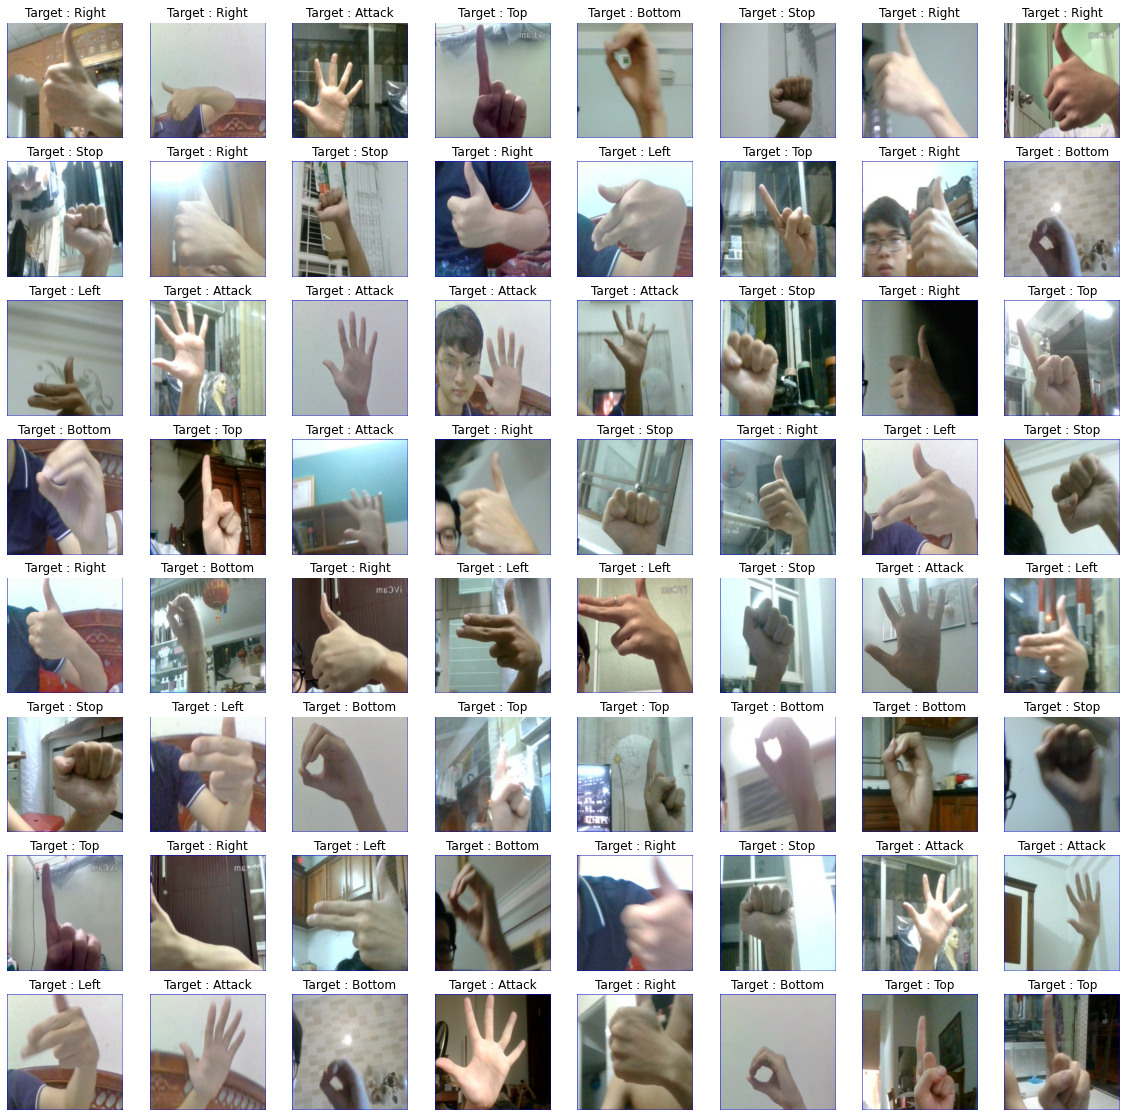

In [7]:
target_names = ['Attack', 'Bottom', 'Left', 'Right', 'Stop', 'Top']
images,labels = next(iter(train_loader))
print(images.shape, labels.shape)
plt.subplots(8,8 , figsize=(20,20))
for i, (image, label) in enumerate(zip(images,labels)):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    temp = unorm(image)
    plt.imshow( temp.permute(1, 2, 0))
    plt.title("Target : " + target_names[label.numpy()])
plt.show()

In [8]:
model = models.mobilenet_v2(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(512, 6))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [9]:
summary(model.to(device), (3, 240, 240), batch_size=64, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 120, 120]             864
       BatchNorm2d-2         [64, 32, 120, 120]              64
             ReLU6-3         [64, 32, 120, 120]               0
            Conv2d-4         [64, 32, 120, 120]             288
       BatchNorm2d-5         [64, 32, 120, 120]              64
             ReLU6-6         [64, 32, 120, 120]               0
            Conv2d-7         [64, 16, 120, 120]             512
       BatchNorm2d-8         [64, 16, 120, 120]              32
  InvertedResidual-9         [64, 16, 120, 120]               0
           Conv2d-10         [64, 96, 120, 120]           1,536
      BatchNorm2d-11         [64, 96, 120, 120]             192
            ReLU6-12         [64, 96, 120, 120]               0
           Conv2d-13           [64, 96, 60, 60]             864
      BatchNorm2d-14           [64, 96,

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [11]:
def train(model, train_loader):
    model.train()
    train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # accuracy
        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_train += (labels == predicted).sum().item()
        train_acc = (100 * correct_train) / target_count
    return train_acc, train_loss / target_count

In [12]:
def validate(model,val_loader):
    model.eval()
    val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_val += (labels == predicted).sum().item()
        val_acc = (100 * correct_val) / target_count
    return val_acc, val_loss / target_count 

In [13]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

# Early stopping
the_last_loss = 100
patience = 10
trigger_times = 0
isStopped = False

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

for epoch in range(0, num_epochs):
    
    train_acc, train_loss = train(model, train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    val_acc,val_loss = validate(model, test_loader)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    print("Epoch {0}: train_acc {1} \t train_loss {2} \t val_acc {3} \t val_loss {4}".format(epoch, train_acc, train_loss, val_acc, val_loss))
    
    the_current_loss = val_loss
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times: ', trigger_times)
        if trigger_times >= patience:
            print('Early stopping! at epoch {0}'.format(epoch))
            isStopped = True
            break
    else:
        print('trigger times: 0')
        trigger_times = 0
        the_last_loss = the_current_loss
        if not isStopped:
            torch.save(model.state_dict(), 'hand_model18.pt')
            print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

Epoch 0: train_acc 97.31770833333333 	 train_loss 0.0020496660894544524 	 val_acc 95.92013888888889 	 val_loss 0.002190141729083608
trigger times: 0
Validation loss 0.002190.  Saving model ...
Epoch 1: train_acc 99.30208333333333 	 train_loss 0.00032717024005611014 	 val_acc 99.35763888888889 	 val_loss 0.00026213108480841943
trigger times: 0
Validation loss 0.000262.  Saving model ...
Epoch 2: train_acc 99.23958333333333 	 train_loss 0.0003706356934821997 	 val_acc 99.39236111111111 	 val_loss 0.0003926392396981687
trigger times:  1
Epoch 3: train_acc 99.28125 	 train_loss 0.00039139344553575485 	 val_acc 98.71527777777777 	 val_loss 0.0005514437968147007
trigger times:  2
Epoch 4: train_acc 99.45833333333333 	 train_loss 0.00025823651186849855 	 val_acc 99.6875 	 val_loss 0.00015074031892766814
trigger times: 0
Validation loss 0.000151.  Saving model ...
Epoch 5: train_acc 99.765625 	 train_loss 0.00010867417186721203 	 val_acc 98.80208333333333 	 val_loss 0.0005452498917084426
trigg

In [14]:
model.load_state_dict(torch.load('hand_model18.pt'))

<All keys matched successfully>

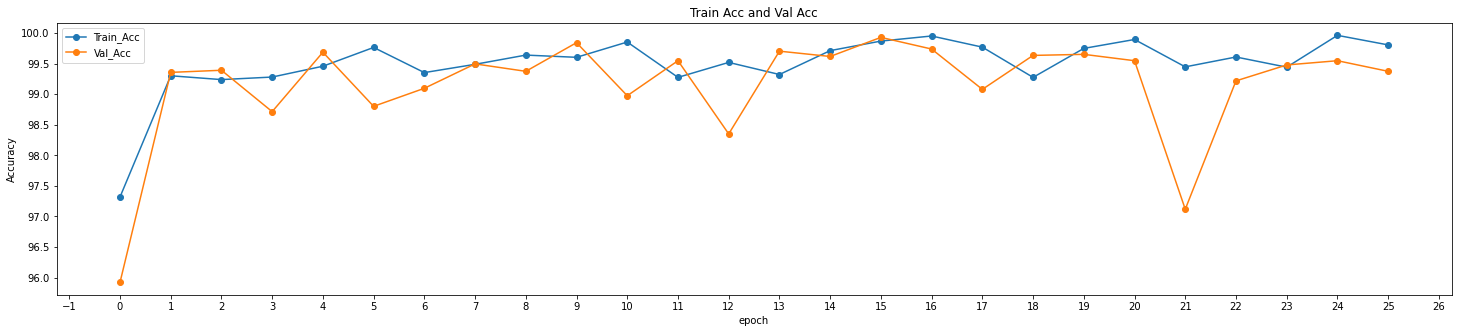

In [15]:
plt.figure(figsize=(25,5))
plt.plot(train_acc_history,'-o')
plt.plot(val_acc_history,'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Acc','Val_Acc'])
plt.title('Train Acc and Val Acc')
plt.show()

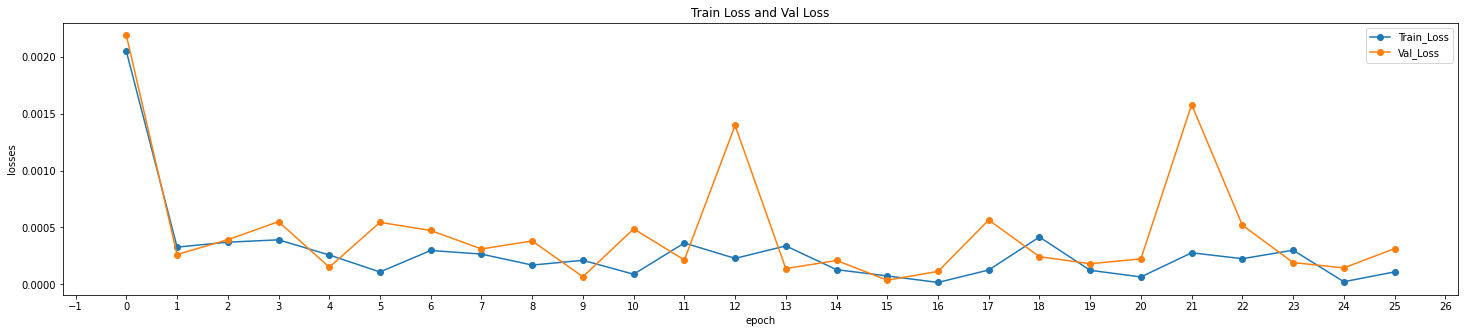

In [16]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Loss','Val_Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [17]:
model.eval()
pred_list = []
label_list = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    running_loss=0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)
        pred_list.extend(predictions.cpu().numpy())
        label_list.extend(labels.cpu().numpy())
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 99.93055555555556 %


In [18]:
from sklearn.metrics import confusion_matrix
cm_percentage=confusion_matrix(label_list,pred_list, normalize='true')
cm_number=confusion_matrix(label_list,pred_list)

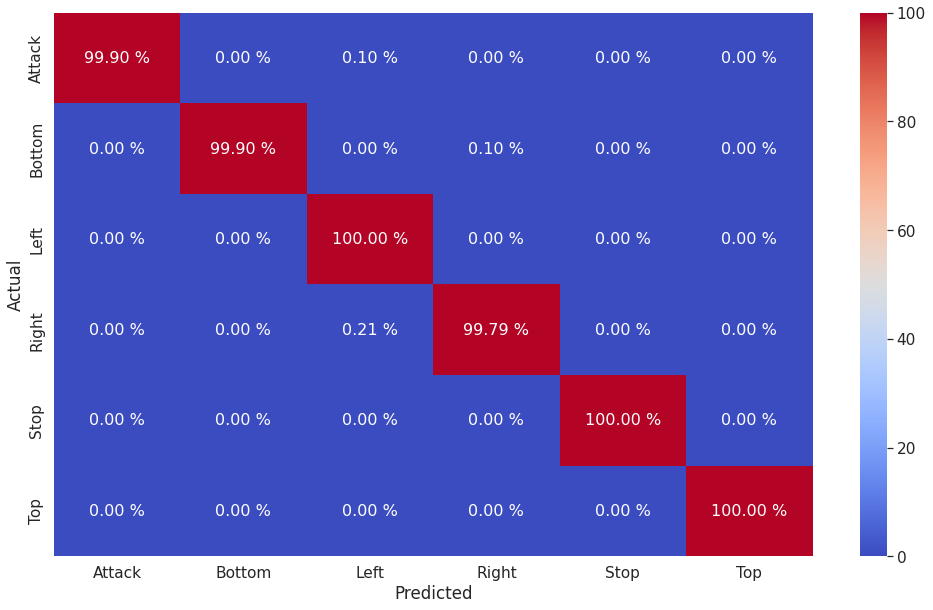

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm_percentage*100, range(6), range(6))
plt.figure(figsize=(17,10))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True,cmap='coolwarm', annot_kws={"size": 16}, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

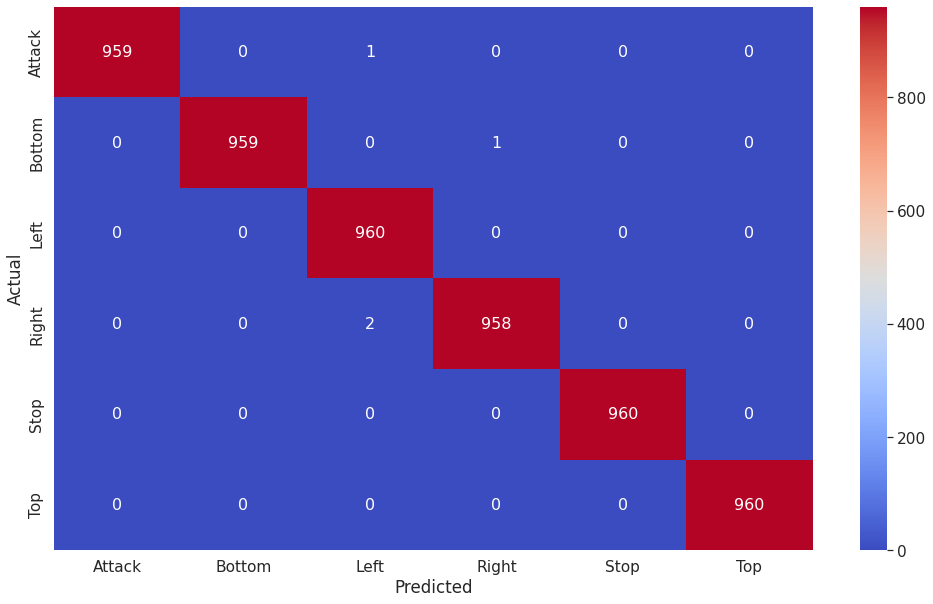

In [20]:
cm_number = cm_number.astype(int)
df_cm = pd.DataFrame(cm_number, range(6), range(6))
plt.figure(figsize=(17,10))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 16}, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)